# Analyse von Luftverschmutzungsdaten

## Daten
- Quelle: die [API](https://aqs.epa.gov/aqsweb/documents/data_api.html#lists) der EPA (US-Umweltbehörde)
- Luftverschmutzung Tagesdaten von Los Angeles von 2019 (Corona Jahre vernachlässigen)

In [1]:
'Import der Module'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as requests
import json
from time import sleep
import os
import seaborn as sns
from additional_functions import * 

'Load df'
df_pollutant=pd.read_csv("Pollution_Data/pollutant_df.csv",index_col=0)

'Define important Variables'
years=[2013,2014,2015,2016,2017,2018,2019]

#API Sign-Up
email="felixsch00@outlook.de"
#response_signup= requests.get(f"https://aqs.epa.gov/data/api/signup?email={email}")
#API Key via E-Mail
api_key="goldfox88" 
#Check if API is available --> 200 is working
response_available=requests.get("https://aqs.epa.gov/data/api/metaData/isAvailable")
print(f"Status Code Available: {response_available.status_code}")

Status Code Available: 200


In [21]:
'Get  some information about the parameters which can be requestet'
#Definitions
response_definition=requests.get(f"https://aqs.epa.gov/data/api/metaData/fieldsByService?email={email}&key={api_key}&service=sampleData")
print(f"Status Code E-Mail and Key okay: {response_definition.status_code}")

#Check available parameter classes (groups of parameter) -> to a JSON File
resp_parameter_classes=requests.get(f"https://aqs.epa.gov/data/api/list/classes?email={email}&key={api_key}")
with open("API_Infos/Parameter_Classes.json","w") as file:
    json.dump(resp_parameter_classes.json(),file,indent=4)
#Parameters from AQI POLLUTANTS   
def get_parameter_from_class(class_code:str,email=email,api_key=api_key):
    """Get the code and definition of available AQ Measurements, stores them in a JSON-File in API_Data Folder

    Args:
        class_code (str): Class Code shown in the Parameters_Classes.json file
        email (_type_, optional): For API. Defaults to email.
        api_key (_type_, optional): For API. Defaults to api_key.
    """
    parameters_api={"email":email,"key":api_key,"pc":class_code}
    req_parameters=requests.get("https://aqs.epa.gov/data/api/list/parametersByClass?",params=parameters_api)
    with open(f"API_Infos/Parameter_{class_code}.json","w") as file:
        json.dump(req_parameters.json(),file,indent=4)
    print(f"{class_code} Parameters successfully print to json file")
    return 

#Basic Pollutants
get_parameter_from_class("AQI POLLUTANTS")
#Meteorological Parameters
get_parameter_from_class("MET")
#Volatile organic compounds
get_parameter_from_class("VOC")



Status Code Available: 200
Status Code E-Mail and Key okay: 200
AQI POLLUTANTS Parameters successfully print to json file
MET Parameters successfully print to json file
VOC Parameters successfully print to json file


## Daten 

### API
AQS-API der US (EPA)[https://aqs.epa.gov/aqsweb/documents/data_api.html]

### Welche zeitliche Intervalle soll ich in meiner Analyse beobachten ?
- es können Daten bis zu den Messintervallen abgerufen werden (SampleData) -> damit könnte ich eigenen Intervalle (z.B. 6h) durch Mittelwertbildung berechnen
- einfacher ist es einfach die **täglichen Daten** Maxima zu betrachten (für eine genauere Betrachtung können ja auch die Mittelwerte betrachtet werden) --> Daily Summary Data by Site

### Messstadionen
- wichtig ist die Auswahl von drei zentral gelegenen Messstadionen. In einer [Kartenansicht](https://epa.maps.arcgis.com/apps/webappviewer/index.html?id=5f239fd3e72f424f98ef3d5def547eb5&extent=-146.2334,13.1913,-46.3896,56.5319) wurden diese ausgewählt.
    + Los Angeles-North Main Street (Short: LA_N): AQS Site ID 06-037-1103
    + Pico Rivera : AQS Site ID	06-037-1602
    + Compton: AQS Site ID	06-037-1302

![Die drei makierten Messstadionen wurden ausgesucht.](Stations_Map.png) 

### Parameter

In dem Codeblock oben wurden die allgemein verfügbaren Messsubstanzen in JSON Files geschrieben. 
Zu den spannenden Schadstoffen (inkl Code für API) zählt: 
- CO 42101
- SO2 42401
- NO2 42602
- O3 44201
- PM10 (Feinstaub) 81102 (0-10um gesamt)
- PM2.5 88101 
- (Total NMOC 43102 (alle VOC ohne CH4))

#### CO 42101
- verschiedene SampleDurations (1h und 8h) -> hier 1h verwenden
- Einheit: ppm
- Um fehlerhafte Messungen auszuschließen muss bei validity_indicator "Y" sein und observation_percentage > 40 % sein

#### NO2
- SampeDuration: "1 HOUR"

#### SO2
- Sample Duration: "5 MINUTE"

#### PM2.5
- SampleDuration: 24 Hour
- Max Hours ist immer 0 --> daher nur date and mean columns

#### O3
- SampleDuration: "8-HR RUN AVG BEGIN HOUR"

#### PM10
- SampleDuration: 24 HOUR
- bei dem gewählten Ort sind nur selten Messwerte vorhanden

### AirQualityIndex (AQI)

siehe https://www.eea.europa.eu/themes/air/air-quality-index -> bei About the Eu Air Q Index in der Kartenlegende
!(Eigenes_Projekt/Dokumentation/AQI_index_Bedeutung.png)
!(Eigenes_Projekt/Dokumentation/AQI_index_Tabelle.png)

In [6]:
#IDs for location
id={"la_n":1103,"pico_rivera":1602,"compton":1302}
parameter_pollutant={"CO":42101,"SO2": 42401,"NO2": 42602 ,"O3" :44201,"PM10" : 81102,"PM2.5":88101}


for year in years:
    for parameter in parameter_pollutant.values():
        get_epa_data(parameter,year,site=id["la_n"],folder="Pollution_Data/raw")

Already exists: Year: 2013, Parameter: 42101, Site: 1103
Already exists: Year: 2013, Parameter: 42401, Site: 1103
Already exists: Year: 2013, Parameter: 42602, Site: 1103
Already exists: Year: 2013, Parameter: 44201, Site: 1103
Already exists: Year: 2013, Parameter: 81102, Site: 1103
Already exists: Year: 2013, Parameter: 88101, Site: 1103
Already exists: Year: 2014, Parameter: 42101, Site: 1103
Already exists: Year: 2014, Parameter: 42401, Site: 1103
Already exists: Year: 2014, Parameter: 42602, Site: 1103
Already exists: Year: 2014, Parameter: 44201, Site: 1103
Already exists: Year: 2014, Parameter: 81102, Site: 1103
Already exists: Year: 2014, Parameter: 88101, Site: 1103
Already exists: Year: 2015, Parameter: 42101, Site: 1103
Already exists: Year: 2015, Parameter: 42401, Site: 1103
Already exists: Year: 2015, Parameter: 42602, Site: 1103
Already exists: Year: 2015, Parameter: 44201, Site: 1103
Already exists: Year: 2015, Parameter: 81102, Site: 1103
Already exists: Year: 2015, Par

In [15]:
"Concat  json Pollution files to one large file per different pollution. "
# 88101 is PM2.5
for parameter in [88101]:
    all_df=[]
    for year in years:
        path=get_epa_data(parameter,year,id["la_n"],only_get_path=True)
        with open(path) as file:
            data=json.load(file)
        
        df_single_year=pd.json_normalize(data["Data"])
        print(df_single_year.shape)
        df_single_year.drop(labels=["site_number","parameter_code","state_code","county_code","poc","latitude","longitude","datum","parameter","sample_duration_code",
                        "pollutant_standard","units_of_measure","event_type","method_code","method","local_site_name",
                        "site_address","state", "county","city","cbsa_code","cbsa","date_of_last_change",
                        "aqi"]
                ,axis=1,inplace=True)
        all_df.append(df_single_year)
    
    df_88101=pd.DataFrame()
    df_88101=pd.concat(all_df)

print(df_88101.shape)
df_88101=df_88101[df_88101["validity_indicator"]=="Y"]
df_88101=df_88101[df_88101["observation_percent"]>50]
print(df_88101.shape)
df_88101["date"] = pd.to_datetime(df_88101["date_local"],format="%Y-%m-%d")
#print(df_88101.describe())
df_88101.drop(labels=["first_max_value","first_max_hour","sample_duration","date_local","observation_percent","validity_indicator","observation_count"],inplace=True,axis=1)
df_88101.columns = ["mean_pm2_5","date"]
df_88101=df_88101.groupby(["date"]).mean()
df_88101.info()
df_88101.head(10)
df_88101.info()
df_88101.head(5)


(2412, 32)
(828, 32)
(2382, 32)
(2466, 32)
(2514, 32)
(2436, 32)
(2508, 32)
(15546, 8)
(15546, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2013-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pm2_5  2228 non-null   float64
dtypes: float64(1)
memory usage: 34.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2013-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pm2_5  2228 non-null   float64
dtypes: float64(1)
memory usage: 34.8 KB


,mean_pm2_5
date,
2013-01-01,21.60
2013-01-02,12.90
2013-01-03,12.40
2013-01-04,11.25
2013-01-05,16.20


In [8]:
"Concat json Pollution files to one large file per different pollution. The Result will be stored as df in the all_pollutants list (except pm2.5 which is processed above seperatly)"
all_pollutants=[]
for key,parameter in {"co":42101,"so2": 42401,"no2": 42602 ,"o3" :44201}.items():
    all_years=[]
    print(key)
    print(parameter)
    for year in years:
        path=get_epa_data(parameter,year,id["la_n"],only_get_path=True)
        with open(path) as file:
            data=json.load(file)
        
        df_single_year=pd.json_normalize(data["Data"])
        print(df_single_year.shape)
        df_single_year.drop(labels=["site_number","parameter_code","state_code","county_code","poc","latitude","longitude","datum","parameter","sample_duration_code",
                        "pollutant_standard","units_of_measure","event_type","method_code","method","local_site_name",
                        "site_address","state", "county","city","cbsa_code","cbsa","date_of_last_change",
                        "aqi"]
                ,axis=1,inplace=True)
        all_years.append(df_single_year)
    
    
    df_single_pollutant=pd.DataFrame()
    df_single_pollutant=pd.concat(all_years)

    print(df_single_pollutant.shape)
    df_single_pollutant=df_single_pollutant[df_single_pollutant["validity_indicator"]=="Y"]
    df_single_pollutant=df_single_pollutant[df_single_pollutant["observation_percent"]>50]
    print(df_single_pollutant.shape)
    df_single_pollutant["date"] = pd.to_datetime(df_single_pollutant["date_local"],format="%Y-%m-%d")
    #print(df_single_pollutant.describe())
    df_single_pollutant.drop(labels=["sample_duration","date_local","observation_percent","validity_indicator","observation_count"],inplace=True,axis=1)
    print(df_single_pollutant.columns)
    df_single_pollutant.columns = [f"mean_{key}",f"max_value_{key}",f"max_hour_{key}","date"]
    df_single_pollutant=df_single_pollutant.groupby(["date"]).agg({f"mean_{key}":"mean",f"max_value_{key}":"max",f"max_hour_{key}":"mean"})
    df_single_pollutant[f"max_hour_{key}"]=np.round(df_single_pollutant[f"max_hour_{key}"])
    df_single_pollutant[f"max_hour_{key}"]=df_single_pollutant[f"max_hour_{key}"].astype("int8")
    df_single_pollutant.info()
    df_single_pollutant.head(10)
    df_single_pollutant.info()
    df_single_pollutant.head(10)
    all_pollutants.append(df_single_pollutant)


co
42101
(1447, 32)
(1453, 32)
(1096, 32)
(1365, 32)
(1381, 32)
(1247, 32)
(1014, 32)
(9003, 8)
(8864, 8)
Index(['arithmetic_mean', 'first_max_value', 'first_max_hour', 'date'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2554 entries, 2013-01-01 to 2019-12-31
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_co       2554 non-null   float64
 1   max_value_co  2554 non-null   float64
 2   max_hour_co   2554 non-null   int8   
dtypes: float64(2), int8(1)
memory usage: 62.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2554 entries, 2013-01-01 to 2019-12-31
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_co       2554 non-null   float64
 1   max_value_co  2554 non-null   float64
 2   max_hour_co   2554 non-null   int8   
dtypes: float64(2), int8(1)
memory usage: 62.4 KB
so2
42401
(1763, 32)
(1809, 

In [9]:
'Fügt alle Werte zusammen'
df_pollutant=pd.concat([*all_pollutants,df_88101],axis=1)
df_pollutant.info()




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2556 entries, 2013-01-01 to 2019-12-31
Freq: D
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mean_co        2554 non-null   float64
 1   max_value_co   2554 non-null   float64
 2   max_hour_co    2554 non-null   float64
 3   mean_so2       2435 non-null   float64
 4   max_value_so2  2435 non-null   float64
 5   max_hour_so2   2435 non-null   float64
 6   mean_no2       2443 non-null   float64
 7   max_value_no2  2443 non-null   float64
 8   max_hour_no2   2443 non-null   float64
 9   mean_o3        2457 non-null   float64
 10  max_value_o3   2457 non-null   float64
 11  max_hour_o3    2457 non-null   float64
 12  mean_pm2_5     2228 non-null   float64
dtypes: float64(13)
memory usage: 279.6 KB


In [10]:
# add the aqi column
df_aqi=df_pollutant.apply(func=calc_aqi,axis=1,result_type="expand")
df_aqi.columns=["AQI","AQI_pollutant"]
df_pollutant=pd.concat([df_pollutant,df_aqi],axis=1)

In [11]:
df_pollutant.to_csv("Pollution_Data/pollutant_df.csv")
df_pollutant.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2556 entries, 2013-01-01 to 2019-12-31
Freq: D
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mean_co        2554 non-null   float64
 1   max_value_co   2554 non-null   float64
 2   max_hour_co    2554 non-null   float64
 3   mean_so2       2435 non-null   float64
 4   max_value_so2  2435 non-null   float64
 5   max_hour_so2   2435 non-null   float64
 6   mean_no2       2443 non-null   float64
 7   max_value_no2  2443 non-null   float64
 8   max_hour_no2   2443 non-null   float64
 9   mean_o3        2457 non-null   float64
 10  max_value_o3   2457 non-null   float64
 11  max_hour_o3    2457 non-null   float64
 12  mean_pm2_5     2228 non-null   float64
 13  AQI            2556 non-null   int64  
 14  AQI_pollutant  2556 non-null   object 
dtypes: float64(13), int64(1), object(1)
memory usage: 319.5+ KB


## Daten zur Vorhersage der Schadstoffe

### Meterologische Daten aus der AQS API der EPA


Die folgenden Parameter werden abgerufen: 
- Wind-Geschwindigkeit (in Knoten)
- Wind-Richtung (beides vektoriell, auch als Resultant bezeichnet) (in Grad Kompass)
- Temperatur (raw: Fahrenheit -> Celsius) 
- Tempertur max 
- Feuchtigkeit (in %) + max
- Solar radiation (langleys/minute)
- UV radiation  (")
- barometric pressure (in mbar)

Gut wären außerdem noch (an Stadion nicht verfügbar):
- min T 62105 -> NOAA 
- differenz min max T 62106 oder selbst berechnen -> NOAA
- visibility 63101
- rain 65101 -> NOAA
- Cloud cover 66101

vieleicht hier zu finden (https://www.ncdc.noaa.gov/cdo-web/webservices)

### Kalenderdaten
- Wochentag
- Monat

In [14]:
meterologic_parameter={"wind_speed":61103 , "wind_direction":61104, "temp":62101,
                       "humidity":62201,"radiation":63301, "uv_radiation": 63302,
                       "pressure":64101}

site_la_north=1103

for year in [2019]:
    for parameter in meterologic_parameter.values(): 
        get_epa_data(parameter,year,site_la_north,folder="Predictor_Data/raw_aqs")

Already exists: Year: 2019, Parameter: 61103, Site: 1103
Already exists: Year: 2019, Parameter: 61104, Site: 1103
Already exists: Year: 2019, Parameter: 62101, Site: 1103
Already exists: Year: 2019, Parameter: 62201, Site: 1103
Already exists: Year: 2019, Parameter: 63301, Site: 1103
Already exists: Year: 2019, Parameter: 63302, Site: 1103
Already exists: Year: 2019, Parameter: 64101, Site: 1103
Request Empty


In [45]:
# all not available
#parameter_test={"min_t":62105,"diff_temp": 62106, "visibility":63101,
                #"rain":65102,"cloud_cover":66101}
parameter_test=[61105,61106,61120,61202,62108]

for year in [2019]:
    for parameter in parameter_test:
        print(parameter)
        get_epa_data(parameter,year,1103,folder="Predictor_Data/raw_aqs")

61105
Request Empty
61106
Request Empty
61120
Request Empty
61202
Request Empty
62108
Request Empty


### Daten zum Stromverbrauch 
Daten aus der API der EIA und beziehen sich auf das ganze County Los Angeles in einer täglichen Basis. Dabei sind leider nur die Daten ab Mitte 2015 verfügbar. 
- demand: in MWh
- net_generation: in MWh  

Die URL zum API Request wurde dabei in einem [Online-Tool](https://www.eia.gov/opendata/browser/) erstellt.

In [8]:
'Load the electricity data from EIA API'
'Note: The request string is constructed online via an interface'
eia_apikey="ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e"
"api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&"
#reguest the net generation of electricity in the LA region
req_net_generation=requests.get("https://api.eia.gov/v2/electricity/rto/daily-region-data/data/?api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&frequency=daily&data[0]=value&facets[type][]=NG&facets[respondent][]=LDWP&facets[timezone][]=Pacific&start=2015-06-30&end=2019-12-31&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000")
req_demand=requests.get("https://api.eia.gov/v2/electricity/rto/daily-region-data/data/?api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&frequency=daily&data[0]=value&facets[respondent][]=LDWP&facets[timezone][]=Pacific&facets[type][]=D&start=2015-06-30&end=2019-12-31&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000")
with open("Predictor_Data/electricity_net_generation.json","w") as file:
                json.dump(req_net_generation.json(),file,indent=4)
with open("Predictor_Data/electricity_demand.json","w") as file:
                json.dump(req_demand.json(),file,indent=4)

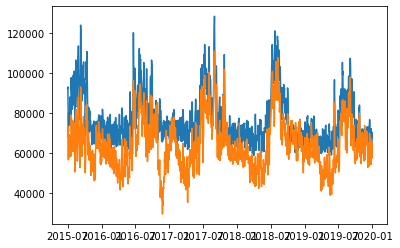

In [5]:
with open("Predictor_Data/electricity_demand.json") as file:
    electricity_demand=pd.json_normalize(json.load(file)["response"]["data"])
    
with open("Predictor_Data/electricity_net_generation.json") as file:
    electricity_net_generation=pd.json_normalize(json.load(file)["response"]["data"])

#change columnames and make date column
electricity_demand["demand_electricity"]=electricity_demand["value"]
electricity_net_generation["net_generation_electricity"]=electricity_net_generation["value"]
electricity_demand["date"]=pd.to_datetime(electricity_demand["period"],format="%Y-%m-%d")
electricity_net_generation["date"]=pd.to_datetime(electricity_net_generation["period"],format="%Y-%m-%d")

# delete other columns and set date as index
electricity_demand=electricity_demand[["date","demand_electricity"]].set_index("date")
electricity_net_generation=electricity_net_generation[["date","net_generation_electricity"]].set_index("date")


electricity=pd.concat([electricity_demand,electricity_net_generation],axis=1)
electricity.to_csv("Predictor_Data/electricity.csv")

#plt.plot(electricity.index,electricity["demand_electricity"])
#plt.plot(electricity.index,electricity["net_generation_electricity"])

### Wetter Daten 
Um weitere Wetter Daten zu erhaten wird auf die Daten der [NOAA](https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND) zurückgegriffen. Dabei werden die Daily Summary Daten online als .csv abgerufen. 
- rain in mm/m²
- t_max in °C
- t_min in °C
- t_minmax als berechnete Differenz zwischen den beiden Werten  
  
Die Daten sind hier ab 2010 bis 2020 abgerufen.

In [42]:
# load the csv File and process it 
wheather=pd.read_csv("Predictor_Data/wheater_raw.csv")
wheather=wheather[["DATE","PRCP","TMAX","TMIN"]]
wheather["DATE"] = pd.to_datetime(wheather["DATE"],format="%Y-%m-%d")
wheather=wheather.set_index("DATE")
wheather.columns = ["rain","t_max","t_min"]
#new columns
wheather["t_minmax"]=wheather["t_max"]-wheather["t_min"]
wheather.info()
wheather.to_csv("Predictor_Data/wheather.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2010-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rain      3652 non-null   float64
 1   t_max     3652 non-null   float64
 2   t_min     3652 non-null   float64
 3   t_minmax  3652 non-null   float64
dtypes: float64(4)
memory usage: 142.7 KB
